In [78]:
# Load data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
data = yf.download(tickers = 'AAPL', start = '2006-12-01',end = '2016-01-01')
data = pd.read_csv("AAPL_yfinance_data.csv")
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-12-01,3.278571,3.297500,3.217857,3.261429,2.761124,795079600
1,2006-12-04,3.281429,3.287500,3.232143,3.254286,2.755077,709536800
2,2006-12-05,3.273214,3.297500,3.245357,3.259643,2.759612,662838400
3,2006-12-06,3.237143,3.263929,3.202500,3.208214,2.716072,638184400
4,2006-12-07,3.215357,3.232143,3.103571,3.108571,2.631715,1004827600
5,2006-12-08,3.115357,3.192500,3.107143,3.152143,2.668602,784277200
6,2006-12-11,3.175000,3.189286,3.144643,3.169643,2.683418,499780400
7,2006-12-12,3.164643,3.172857,3.054643,3.076429,2.604503,1026620000
8,2006-12-13,3.141071,3.181071,3.112500,3.180357,2.692489,857052000
9,2006-12-14,3.180357,3.214286,3.152143,3.162500,2.677371,832330800


In [79]:
# Load new sentiment analysis data
apple = pd.read_csv("aaplCombined.csv")
apple['Date'] = pd.to_datetime(apple['Date'], format='%d-%m-%y').dt.strftime('%Y-%m-%d')
apple.head()


,Date,compound,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-12,0.7707,3.217857,3.278571,795079600,3.297500,3.261429,2.809276
1,2006-04-12,0.8720,3.232143,3.281429,709536800,3.287500,3.254286,2.803123
2,2006-05-12,0.0000,3.245357,3.273214,662838400,3.297500,3.259643,2.807738
3,2006-06-12,0.6858,3.202500,3.237143,638184400,3.263929,3.208214,2.763438
4,2006-07-12,-0.6712,3.103571,3.215357,1004827600,3.232143,3.108571,2.677609


In [80]:
# Understand the data
unique_dates = apple['Date'].unique()
pattern_counts = pd.Series([len(date.split('-')) for date in unique_dates]).value_counts()
pattern_counts, unique_dates[:20]

(3    2517
 Name: count, dtype: int64,
 array(['2006-01-12', '2006-04-12', '2006-05-12', '2006-06-12',
        '2006-07-12', '2006-08-12', '2006-11-12', '2006-12-12',
        '2006-12-13', '2006-12-14', '2006-12-15', '2006-12-18',
        '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22',
        '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29'],
       dtype=object))

In [81]:
# Fix errors in the data
try:
    apple['Date'] = pd.to_datetime(apple['Date'], format='%d-%m-%y')
except Exception as e:
    error_message = str(e)

apple['Date'].head(), error_message if 'error_message' in locals() else "Conversion successful"

(0    2006-01-12
 1    2006-04-12
 2    2006-05-12
 3    2006-06-12
 4    2006-07-12
 Name: Date, dtype: object,
 'time data "2006-01-12" doesn\'t match format "%d-%m-%y", at position 0. You might want to try:\n    - passing `format` if your strings have a consistent format;\n    - passing `format=\'ISO8601\'` if your strings are all ISO8601 but not necessarily in exactly the same format;\n    - passing `format=\'mixed\'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.')

In [82]:
# confirming the datatypes
print("Data type in 'data' DataFrame:", data['Date'].dtype)
print("Data type in 'apple' DataFrame:", apple['Date'].dtype)

Data type in 'data' DataFrame: object
Data type in 'apple' DataFrame: object


In [83]:
# merging the two datasets
data['Date'] = pd.to_datetime(data['Date'])
apple['Date'] = pd.to_datetime(apple['Date'])

apple_filtered = apple[['Date', 'compound']]
data = pd.merge(apple_filtered, data, on='Date', how='inner')

In [84]:
# Adding Financial indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date', 'index'], axis=1, inplace=True)

In [85]:
# Only 9 predictors, and 1 output variable
data_set = data.iloc[:, 0:10]
pd.set_option('display.max_columns', None)

data_set.head(20)

,compound,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target
0,0.7832,4.178929,4.232143,3.986429,3.539088,47.125075,4.527977,4.252771,3.956821,-0.666931
1,0.9230,4.357500,4.410714,4.279286,3.690569,48.557352,4.511911,4.254880,3.962152,-0.731737
2,-0.2263,4.427143,4.446429,4.303571,3.695406,48.604986,4.497920,4.257061,3.967488,-0.507477
3,-0.9874,4.364643,4.605714,4.321429,3.857166,50.255286,4.503458,4.262982,3.975284,-0.679898
4,-0.9702,4.686429,4.741071,4.654643,4.006531,51.786889,4.525271,4.272279,3.985313,-0.790221
5,0.9729,4.753214,4.762143,4.634286,3.962993,51.293640,4.540110,4.280374,3.994528,-0.570896
6,0.8658,4.661786,4.834643,4.636071,4.090890,52.711199,4.567922,4.291300,4.005623,-0.765260
7,0.9465,4.763929,4.809286,4.717857,3.998669,51.552093,4.582712,4.299853,4.015127,-0.843724
8,-0.6486,4.678214,4.728929,4.522500,3.834491,49.476780,4.577624,4.304396,4.021937,-0.584570
9,0.0000,4.638571,4.792143,4.626429,4.054001,52.231506,4.597714,4.313984,4.032091,-0.618600


In [86]:
# Scale the data from -1 to 1.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[ 0.78328484 -0.91269737 -0.91509452 ... -0.98710825 -1.
   0.74531173]
 [ 0.92354771 -0.90109417 -0.90346365 ... -0.98694996 -0.99959
   0.71434687]
 [-0.22955754 -0.89656891 -0.90113745 ... -0.98678631 -0.9991796
   0.82150054]
 ...
 [-0.38557239  0.56351006  0.56279527 ...  0.87335891  0.93468198
   0.09760454]
 [ 0.31674526  0.55327607  0.59112806 ...  0.87059819  0.93272038
  -0.25013778]
 [ 0.35988763  0.57959221  0.57924124 ...  0.86736457  0.93042311
  -0.28633208]]


In [87]:
# multiple feature from data provided to the model
X = []
backcandles = 15 # provides the best preformance
print(data_set_scaled.shape[0])
for j in range(10):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1]) # target as output variable
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

1875
[[[ 0.78328484 -0.91269737 -0.91509452 ... -0.98710825 -1.
    0.74531173]
  [ 0.92354771 -0.90109417 -0.90346365 ... -0.98694996 -0.99959
    0.71434687]
  [-0.22955754 -0.89656891 -0.90113745 ... -0.98678631 -0.9991796
    0.82150054]
  ...
  [-0.1777867  -0.96328742 -0.96906186 ... -0.98224629 -0.99316534
    0.81781242]
  [ 0.26096117 -0.94077715 -0.94193861 ... -0.98298997 -0.99339816
    0.68782804]
  [-0.71134745 -0.87702911 -0.88159756 ... -0.98247428 -0.99277471
    0.58463567]]

 [[ 0.92354771 -0.90109417 -0.90346365 ... -0.98694996 -0.99959
    0.71434687]
  [-0.22955754 -0.89656891 -0.90113745 ... -0.98678631 -0.9991796
    0.82150054]
  [-0.99317749 -0.90063003 -0.89076275 ... -0.98634194 -0.99857999
    0.73911602]
  ...
  [ 0.26096117 -0.94077715 -0.94193861 ... -0.98298997 -0.99339816
    0.68782804]
  [-0.71134745 -0.87702911 -0.88159756 ... -0.98247428 -0.99277471
    0.58463567]
  [ 0.98505067 -0.78926242 -0.7927144  ... -0.97997687 -0.99079405
    0.53245058]]


In [88]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1488
(1488, 15, 10)
(372, 15, 10)
(1488, 1)
(372, 1)
[[ 0.53245058]
 [ 0.67701111]
 [ 0.73883715]
 ...
 [-0.17866236]
 [-0.26300606]
 [-0.21449668]]


In [97]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#np.random.seed(10) 

lstm_input = Input(shape=(backcandles, 10), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
90/90 [==============================] - 7s 24ms/step - loss: 0.0334 - val_loss: 0.0315
Epoch 2/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0165 - val_loss: 0.0574
Epoch 3/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0162 - val_loss: 0.0368
Epoch 4/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0159 - val_loss: 0.0364
Epoch 5/30
90/90 [==============================] - 1s 11ms/step - loss: 0.0155 - val_loss: 0.0355
Epoch 6/30
90/90 [==============================] - 1s 11ms/step - loss: 0.0159 - val_loss: 0.0382
Epoch 7/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0367
Epoch 8/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0155 - val_loss: 0.0380
Epoch 9/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0149 - val_loss: 0.0546
Epoch 10/30
90/90 [==============================] - 1s 10ms/step - loss: 0.0152 - val_loss: 0.0370
Epoch 11/

In [98]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

12/12 [==============================] - 1s 6ms/step
[-0.40493974] [-0.51040136]
[-0.48842245] [-0.06375833]
[-0.51254725] [-0.06943514]
[-0.44033656] [-0.18449865]
[-0.41874117] [0.05042937]
[-0.36940676] [0.00010731]
[-0.3535272] [-0.11173002]
[-0.36518684] [-0.07593854]
[-0.3639873] [-0.10869887]
[-0.3672864] [-0.01610562]


In [99]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse

0.1699843673254716

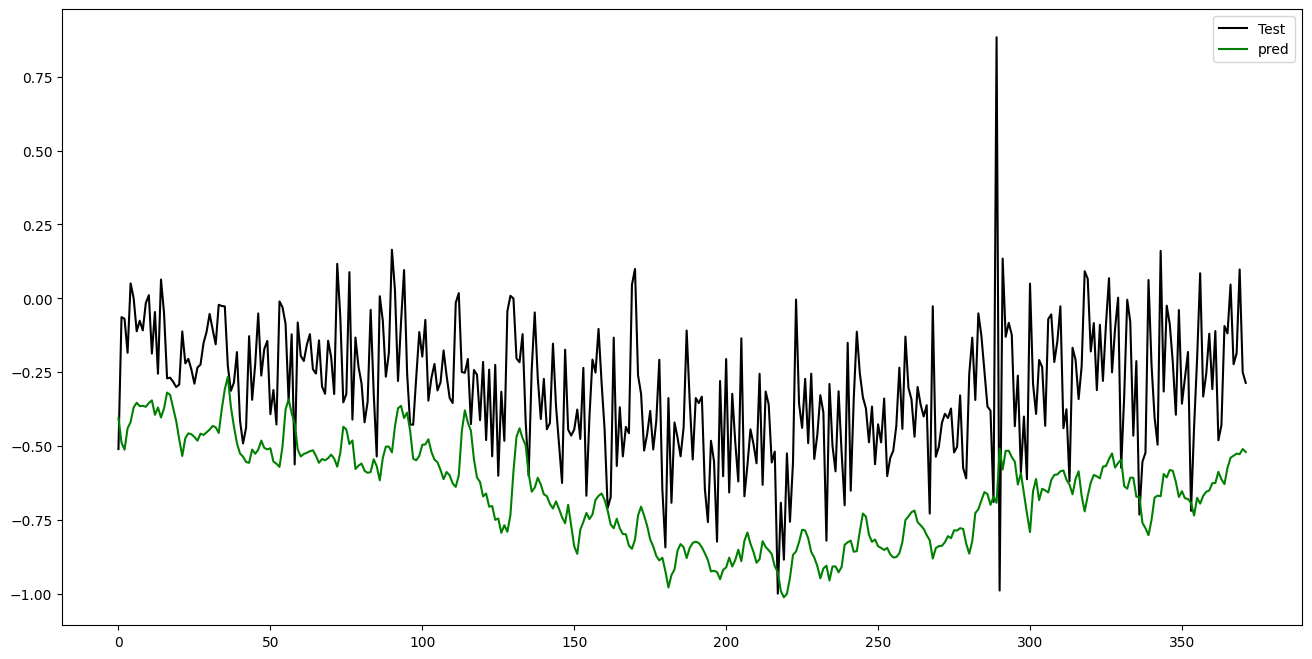

In [100]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()